# Multi- Class Prediction

## Import Modules

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.version

'3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

# Load Data

In [2]:
# load data
loan = pd.read_csv('./data/loan.csv')

/root/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Pre-Processing
Let's quickly explore how this data looks like.

In [3]:
num_rows = loan.shape[0]
# Calculate number of features-1 because we are saving one as the target variable 
n_features = loan.shape[1] - 1

# Print the results
print("Total number of cases: {}".format(num_rows))
print("Number of features: {}".format(n_features))

columns = loan.columns
print(columns)

Total number of cases: 887379
Number of features: 73
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_j

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [5]:
loan = loan.convert_objects(convert_numeric=True)

/root/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [6]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      35 non-null float64
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status             

In [7]:
loan.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_title,annual_inc,title,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,3.500000e+01,8.873750e+05,1.270000e+02,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,1.610516e+07,7.502759e+04,1.420789e+05,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,9.356427e+07,6.469830e+04,9.301942e+05,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,8.000000e+00,4.500000e+04,2.010000e+03,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,1.100000e+01,6.500000e+04,2.013000e+03,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,1.005000e+03,9.000000e+04,4.950000e+03,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,5.537420e+08,9.500000e+06,8.301962e+06,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [8]:
loan.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                      887344
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                          887252
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

In [9]:
counter_nan = loan.isnull().sum()
counter_without_nan = counter_nan[counter_nan==0]

In [10]:
counter_without_nan

id                         0
member_id                  0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length                 0
home_ownership             0
verification_status        0
issue_d                    0
loan_status                0
pymnt_plan                 0
url                        0
purpose                    0
zip_code                   0
addr_state                 0
dti                        0
revol_bal                  0
initial_list_status        0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
policy_code                0
application_ty

There are some columns with huge number of null values that need too be dropped!

In [11]:
null_cols = ['desc',
             'mths_since_last_delinq',
             'mths_since_last_record',
             'next_pymnt_d',
             'mths_since_last_major_derog',
             'annual_inc_joint',
             'dti_joint',
             'verification_status_joint',
             'open_acc_6m',
             'open_il_6m',
             'open_il_12m',
             'open_il_24m',
             'mths_since_rcnt_il',
             'total_bal_il',
             'il_util',
             'open_rv_12m',
             'open_rv_24m',
             'max_bal_bc',
             'all_util',
             'inq_fi',
             'total_cu_tl',
             'inq_last_12m'
             ]

In [12]:
def drop_null_columns(data):
    """Drop columns (most of values are null)"""
    data.drop(null_cols, axis=1, inplace=True)
    return None

In [13]:
drop_null_columns(loan)

In [14]:
loan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,...,Jan-2015,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,...,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,...,Jun-2014,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,...,Jan-2015,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,...,Jan-2016,67.79,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,...,Jan-2015,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
6,1069639,1304742,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,...,Jan-2016,170.08,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
7,1072053,1288686,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,...,Jan-2015,111.34,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
8,1071795,1306957,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,...,Apr-2012,152.39,Aug-2012,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
9,1071570,1306721,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,...,Nov-2012,121.45,Mar-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


## Modifying Target Column

The target column I am interested in is `loan_status`. Let's explore how this column is composed of.

In [15]:
loan.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Meaning of loan status is described below:

|Loan Status|Meaning|
|---:|:---|
|Current|Loan is up to date on all outstanding payments.|
|Fully Paid|Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.|
|Charged Off|Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.|
|Late (31-120 days)|Loan has not been current for 31 to 120 days.|
|Issued|New loan that has passed all LendingClub reviews, received full funding, and has been issued.|
|In Grace Period|Loan is past due but within the 15-day grace period.|
|Late (16-30 days)|Loan has not been current for 16 to 30 days.|
|Default|Loan has not been current for 121 days or more.|

First of all, `Current` and `Issued` loans are still in progress, so they cannot be used for training. Let's split them.

In [16]:
in_progress_index = ['Current', 'Issued']

In [17]:
def split_loan_in_progress(data):
    """Return table of loan in progress. It drops the loan in progress from loan data internally."""
    progress_bool = data.loan_status.isin(in_progress_index)
    loan_in_progress = data[progress_bool].drop('loan_status', axis=1)
    data.drop(list(loan_in_progress.index), axis=0, inplace=True)
    return loan_in_progress

In [18]:
loan_in_progress = split_loan_in_progress(loan)

In [19]:
print("Shape of loan_in_progress:", loan_in_progress.shape)
print("Shape of loan            :", loan.shape)

Shape of loan_in_progress: (610239, 51)
Shape of loan            : (277140, 52)


There are many classes in `loan_status` feature. However, I want to divide it to 3 classses: bad, warning and safe.


<table>
  <tr>
    <td>Loan Status</td>
    <td>Class</td>
    <td>Code</td>
  </tr>
  <tr>
    <td>Fully Paid</td>
    <td rowspan="2">Safe</td>
    <td rowspan="2">2</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Fully Paid</td>
  </tr>
  <tr>
    <td>Late (31-120 days)</td>
    <td rowspan="3">Warning</td>
    <td rowspan="3">1</td>
  </tr>
  <tr>
    <td>Late (16-30 days)</td>
  </tr>
  <tr>
    <td>In Grace Period</td>
  </tr>
  <tr>
    <td>Charged Off</td>
    <td rowspan="3">Bad</td>
    <td rowspan="3">0</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Charged Off</td>
  </tr>
  <tr>
    <td>Default</td>
  </tr>
</table>

This categorization is coded as:

In [20]:
bad_index = ['Charged Off',
             'Does not meet the credit policy. Status:Charged Off',
             'Default'
             ]

warning_index = ['Late (31-120 days)',
                 'Late (16-30 days)',
                 'In Grace Period'          # (Late (1-15 days)
                 ]

safe_index = ['Fully Paid',
              'Does not meet the credit policy. Status:Fully Paid'
              ]

In [21]:
def categorize_target(data):
    """Returns encoded loan status: Safe, Warning and Bad"""

    def func(x):
        if x['loan_status'] in bad_index:
            return 0
        elif x['loan_status'] in warning_index:
            return 1
        else:
            return 2

    data['loan_status_coded'] = data.apply(func, axis=1)
    data.drop('loan_status', axis=1, inplace=True)
    return data

In [22]:
loan = categorize_target(loan)

In [23]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_coded
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2


# Feature Engineering with Exploratory Data Analysis

Now, we have pre-processed data table as `loan`. Let's explore distribution of each features to understand data.

In [24]:
loan.dtypes

id                              int64
member_id                       int64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                     float64
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
pymnt_plan                     object
url                            object
purpose                        object
title                         float64
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc    

### loan_amnt 
* loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

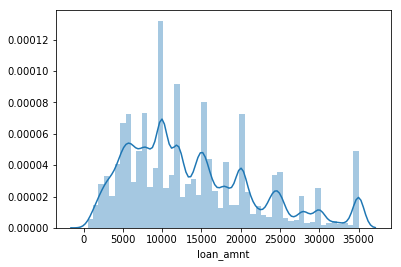

In [25]:
sns.distplot(loan["loan_amnt"])

### funded_amnt, funded_amnt_inv
* funded_amnt: The total amount committed to that loan at that point in time.
* funded_amnt_inv: The total amount committed by investors for that loan at that point in time.

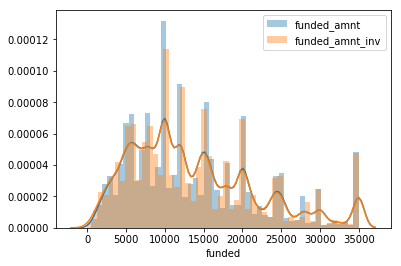

In [26]:
plt.figure()
sns.distplot(loan["funded_amnt"], label="funded_amnt")
sns.distplot(loan["funded_amnt_inv"], label="funded_amnt_inv")
plt.legend()
plt.xlabel("funded")
plt.show()

### term
* term: The number of payments on the loan. Values are in months and can be either 36 or 60.

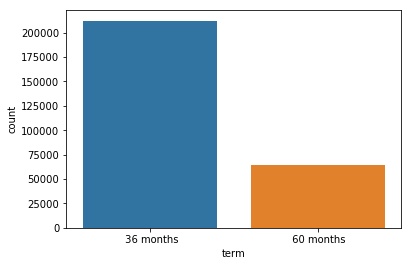

In [27]:
sns.countplot(loan["term"])

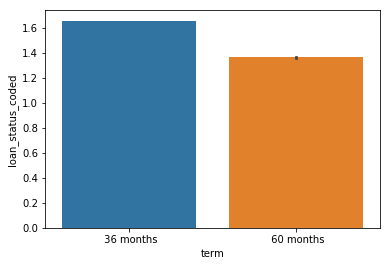

In [28]:
sns.barplot(x="term", y="loan_status_coded", data=loan)

### int_rate
* int_rate: Interest Rate on the loan

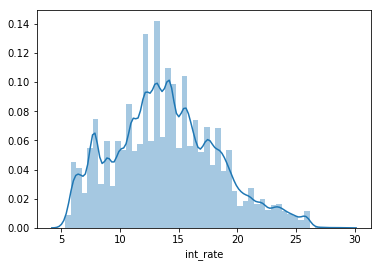

In [29]:
sns.distplot(loan["int_rate"])

### installment

* installment: The monthly payment owed by the borrower if the loan originates.

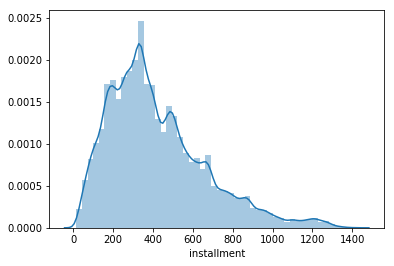

In [30]:
sns.distplot(loan["installment"])

### grade, sub_grade
* grade: LC assigned loan grade
* sub_grade: LC assigned loan subgrade

#### grade

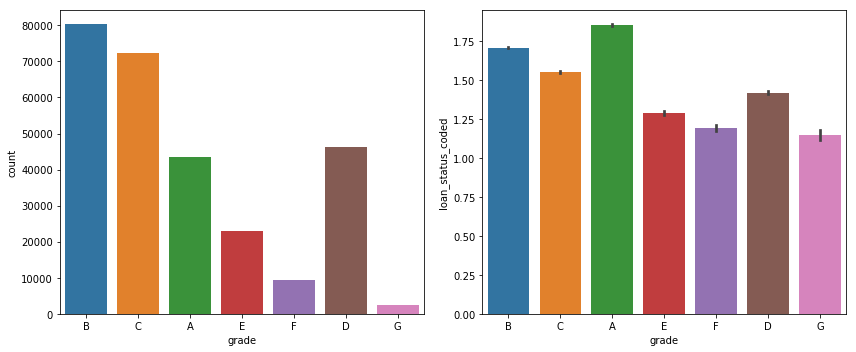

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["grade"])
plt.subplot(1,2,2)
sns.barplot(x="grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

#### sub_grade

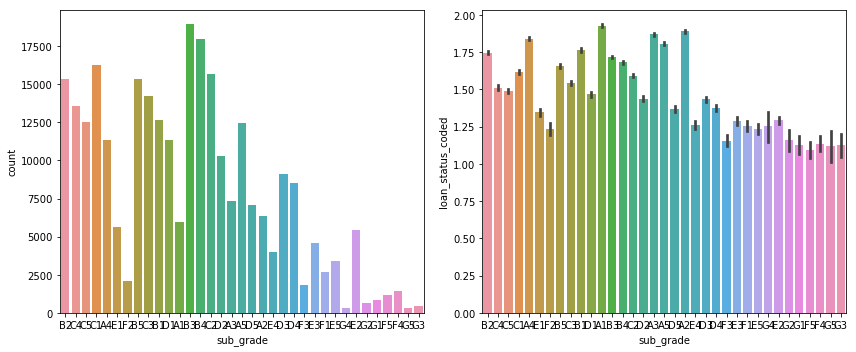

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["sub_grade"])
plt.subplot(1,2,2)
sns.barplot(x="sub_grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

It would be better to extract just a number from `sub_grade` rather than using combined form since the grade information is already provided by `grade` feature.

In [33]:
def ext_num_from_sub_grade(data):
    data['sub_grade'] = data['sub_grade'].map(lambda x: int(x.lstrip('ABCDEFG')))
    return data

In [34]:
ext_num_from_sub_grade(loan)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_coded
0,1077501,1296599,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,2,...,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
1,1077430,1314167,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,1077175,1313524,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,5,...,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
3,1076863,1277178,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,1,...,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
5,1075269,1311441,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,4,...,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
7,1072053,1288686,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,1,...,111.34,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
8,1071795,1306957,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,2,...,152.39,Aug-2012,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
9,1071570,1306721,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,5,...,121.45,Mar-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
10,1070078,1305201,6500.0,6500.0,6500.000000,60 months,14.65,153.45,C,3,...,1655.54,Dec-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
11,1069908,1305008,12000.0,12000.0,12000.000000,36 months,12.69,402.54,B,5,...,6315.30,Aug-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2


In [35]:
loan.sub_grade.value_counts()

4    57124
3    56406
2    55869
1    55389
5    52352
Name: sub_grade, dtype: int64

Now, `sub_grade` feature only contains numeric data. Let's plot this feature again.

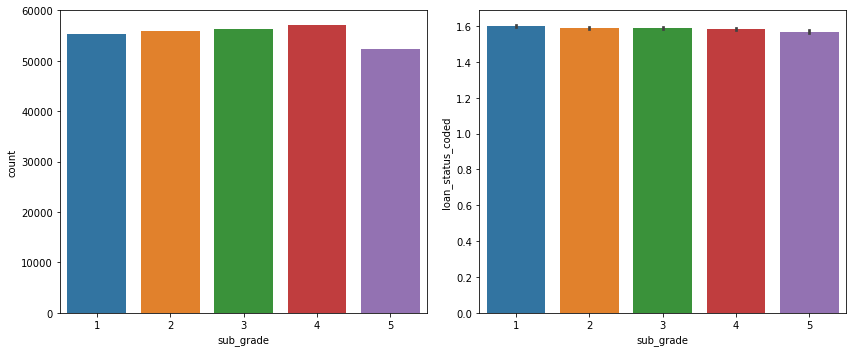

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["sub_grade"])
plt.subplot(1,2,2)
sns.barplot(x="sub_grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

### emp_title
* The job title supplied by the Borrower when applying for the loan.

In [37]:
loan.emp_title.isnull().sum()/loan.shape[0] * 100

99.996752543840657

5% of `emp_title` feature is filled with null value.

In [38]:
loan.emp_title.value_counts().head()

10.0        2
15.0        1
121000.0    1
105000.0    1
1400.0      1
Name: emp_title, dtype: int64

In [39]:
loan.emp_title.value_counts()[0]/loan.shape[0] * 100

KeyError: 0.0

Although the most frequently answered position is 'Manager', but it accounts for only 0.8% of the entire data. I believe this feature can't represent the whole dataset in meaningful way. So I decided to drop this feature.

In [40]:
def drop_emp_title(data):
    data.drop('emp_title', axis=1, inplace=True)
    return None

In [41]:
drop_emp_title(loan)

### emp_length
* emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [42]:
loan.emp_length.value_counts()

10+ years    83918
2 years      25828
< 1 year     23210
3 years      22436
5 years      19518
1 year       18643
4 years      17660
6 years      15999
7 years      15281
8 years      13028
n/a          11101
9 years      10518
Name: emp_length, dtype: int64

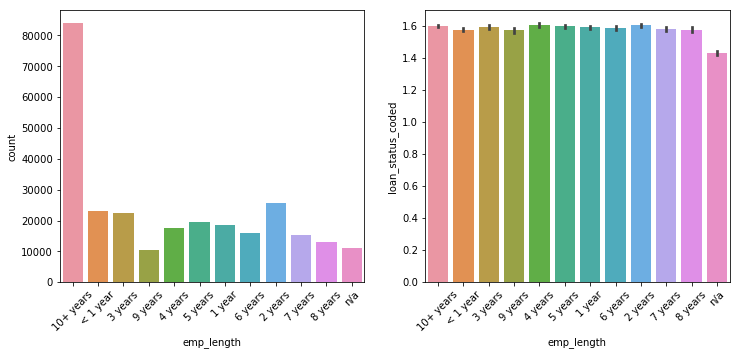

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["emp_length"])
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x="emp_length", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.show()

### home_ownership
* home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [44]:
loan.home_ownership.value_counts()

MORTGAGE    135573
RENT        116948
OWN          24391
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64

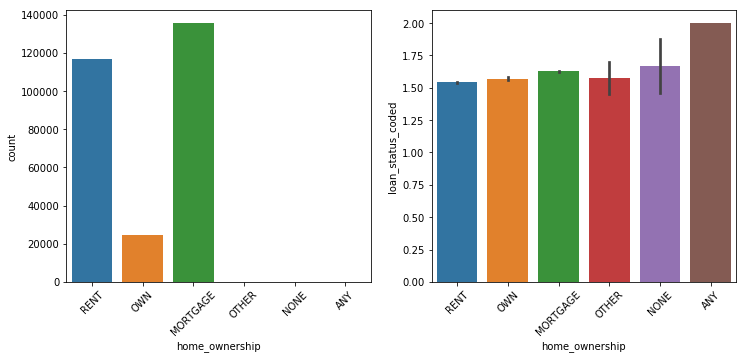

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["home_ownership"])
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x="home_ownership", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.show()

### annual_inc
* annual_inc: The self-reported annual income provided by the borrower during registration.

In [46]:
loan.annual_inc.isnull().sum()

4

There are only 4 missing values. Let's replace them with median value of feature which is more robust to outlier than mean.

In [47]:
print("Median of annual_inc: ", loan.annual_inc.median())
print("Mean of annual_inc:   ", loan.annual_inc.mean())

Median of annual_inc:  62000.0
Mean of annual_inc:    72483.8108708


In [48]:
def fill_na_annual_inc(data):
    data.annual_inc.fillna(data.annual_inc.median(), inplace=True)
    return None

fill_na_annual_inc(loan)

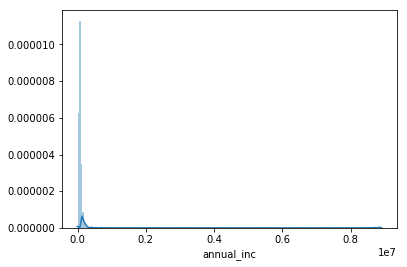

In [49]:
sns.distplot(loan["annual_inc"], bins=200)

We can see that `annual_inc` is heavily skewed with outlier. Let's focus on range of [0,500000)

(0, 500000)

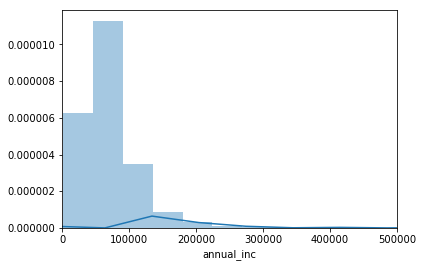

In [50]:
sns.distplot(loan["annual_inc"], bins=200)
plt.xlim(0,500000)

### verification_status
* verification_status

In [51]:
loan.verification_status.value_counts()

Verified           101552
Not Verified        92571
Source Verified     83017
Name: verification_status, dtype: int64

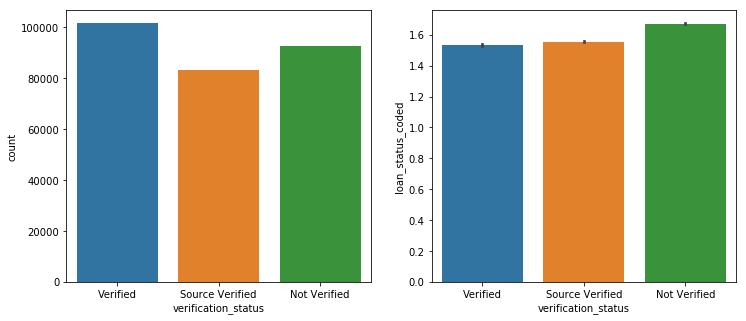

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["verification_status"])
plt.subplot(1,2,2)
sns.barplot(x="verification_status", y="loan_status_coded", data=loan)
plt.show()

### issue_d
* issue_d: The month which the loan was funded

In [53]:
loan.issue_d.value_counts().head()

Oct-2014    10148
Jul-2014     9605
Apr-2014     7357
Dec-2013     7055
May-2014     7052
Name: issue_d, dtype: int64

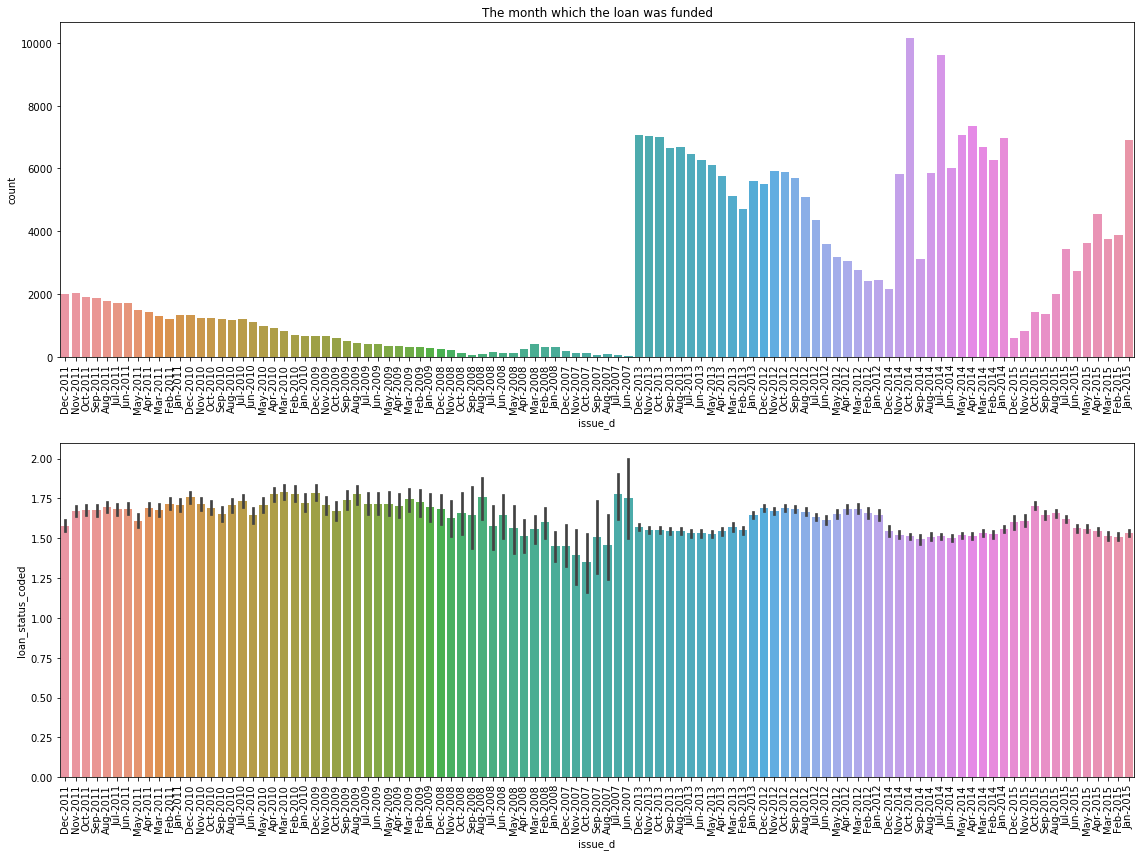

In [55]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.title('The month which the loan was funded')
sns.countplot(loan["issue_d"])
plt.xticks(rotation='vertical')
plt.subplot(2,1,2)
sns.barplot(x="issue_d", y="loan_status_coded", data=loan)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

As we can see in this graph, it is a time-series data. If we include this columns in our analysis, it expands our model dimension for more than 100. However, performance of model is not greatly affected without this feature. So I decided to exclude this feature in this prediction model.

In [56]:
def drop_issue_d(data):
    data.drop('issue_d', axis=1, inplace=True)
    return None
drop_issue_d(loan)

### pymnt_plan
* pymnt_plan: Indicates if a payment plan has been put in place for the loan

In [57]:
loan.pymnt_plan.value_counts()

n    277133
y         7
Name: pymnt_plan, dtype: int64

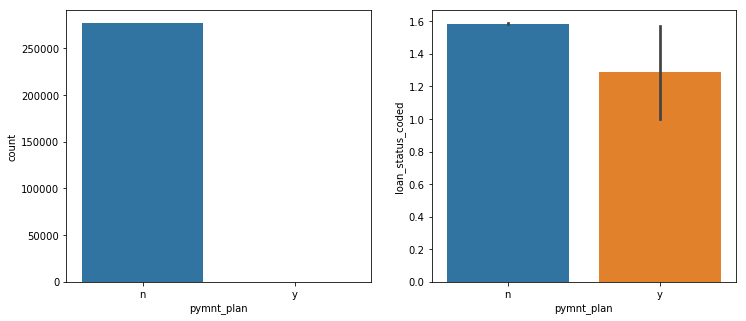

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["pymnt_plan"])
plt.subplot(1,2,2)
sns.barplot(x="pymnt_plan", y="loan_status_coded", data=loan)
plt.show()

In [59]:
def drop_pymnt_plan(data):
    data.drop('pymnt_plan', axis=1, inplace=True)
    return None
drop_pymnt_plan(loan)

### url
* url: URL for the LC page with listing data.

In [60]:
loan.url.head()

0    https://www.lendingclub.com/browse/loanDetail....
1    https://www.lendingclub.com/browse/loanDetail....
2    https://www.lendingclub.com/browse/loanDetail....
3    https://www.lendingclub.com/browse/loanDetail....
5    https://www.lendingclub.com/browse/loanDetail....
Name: url, dtype: object

This is a URL for loan data. Definitely we don't need this to inference default. Let's drop this feature.

In [61]:
def drop_url(data):
    data.drop('url', axis=1, inplace=True)
    return None
drop_url(loan)

### purpose
* purpose: A category provided by the borrower for the loan request. 

In [62]:
loan.purpose.value_counts()

debt_consolidation    163180
credit_card            54276
home_improvement       16356
other                  15807
major_purchase          6785
small_business          5245
car                     3845
medical                 3125
moving                  2241
wedding                 2022
house                   1816
vacation                1733
educational              422
renewable_energy         287
Name: purpose, dtype: int64

This categorical `purpose` feature is well-classified.

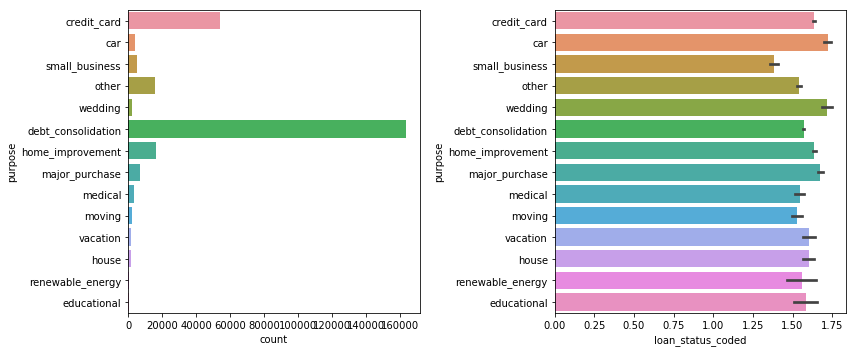

In [63]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(y=loan["purpose"])
plt.subplot(1,2,2)
sns.barplot(y="purpose", x="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

### title
* title: The loan title provided by the borrower

In [66]:
loan.title.value_counts()

2012.0       20
2013.0       17
2010.0       12
10000.0       4
2011.0        4
12.0          3
5000.0        3
8000.0        3
15000.0       3
1.0           2
123.0         2
6000.0        2
4800.0        2
3500.0        2
636.0         1
2800.0        1
10750.0       1
1314.0        1
5200.0        1
5.0           1
36.0          1
0.0           1
2400.0        1
616.0         1
4900.0        1
9600.0        1
9000.0        1
77911.0       1
5082010.0     1
8301962.0     1
25000.0       1
10.0          1
2015.0        1
2003.0        1
4102011.0     1
1000.0        1
996.0         1
3900.0        1
7750.0        1
7300.0        1
12000.0       1
1717.0        1
850.0         1
3311.0        1
13000.0       1
12910.0       1
7000.0        1
1010.0        1
25450.0       1
24000.0       1
Name: title, dtype: int64

In [67]:
loan.title.isnull().sum()

277025

There are 14 null values. Since it is a categorical data, I will fill null values with 'Unkown' value.

In [68]:
def fill_na_title(data):
    data.title.fillna('Unknown', inplace=True)
    return None
fill_na_title(loan)

In [69]:
sum(loan.title=='Unknown')

277025

### zip_code, addr_state
* zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.
* addr_state: The state provided by the borrower in the loan application

In [70]:
loan.zip_code.value_counts().head()

945xx    3520
112xx    3123
750xx    3005
100xx    2739
900xx    2688
Name: zip_code, dtype: int64

It looks like `zip_code` does not represent data effectively. I will drop this feature.

In [71]:
def drop_zip_code(data):
    data.drop('zip_code', axis=1, inplace=True)
    return None
drop_zip_code(loan)

In [72]:
loan.addr_state.value_counts().head()

CA    46519
NY    23694
TX    21193
FL    19329
NJ    10549
Name: addr_state, dtype: int64

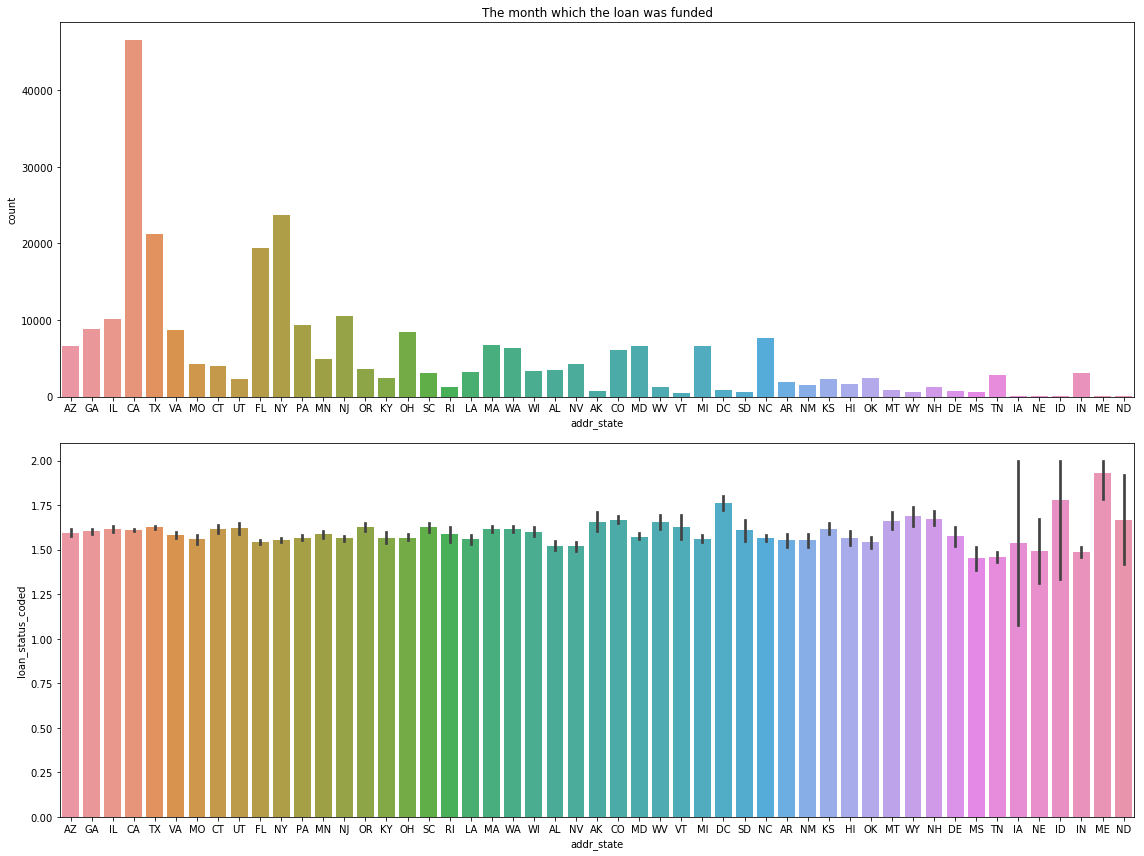

In [73]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.title('The month which the loan was funded')
sns.countplot(loan["addr_state"])
plt.subplot(2,1,2)
sns.barplot(x="addr_state", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

For the same reason as `issue_d`, I will drop this feature.

In [74]:
def drop_addr_state(data):
    data.drop('addr_state', axis=1, inplace=True)
    return None
drop_addr_state(loan)

### dti
* dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

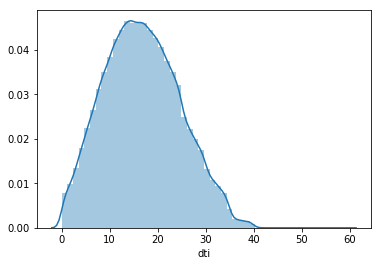

In [75]:
sns.distplot(loan.dti)

### delinq_2yrs
* delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [76]:
loan.delinq_2yrs.isnull().sum()

29

In [77]:
def fill_na_delinq_2yrs(data):
    data.delinq_2yrs.fillna(data.delinq_2yrs.median(), inplace=True)
    return None

In [78]:
fill_na_delinq_2yrs(loan)

Considering the entire number of data, only small number of values are null. Let's fill them with median of column

In [79]:
loan.delinq_2yrs.value_counts()

0.0     230858
1.0      31595
2.0       8957
3.0       3040
4.0       1249
5.0        642
6.0        329
7.0        178
8.0        104
9.0         63
10.0        39
12.0        26
11.0        24
13.0         9
14.0         9
15.0         5
18.0         4
17.0         2
16.0         2
29.0         1
21.0         1
19.0         1
20.0         1
22.0         1
Name: delinq_2yrs, dtype: int64

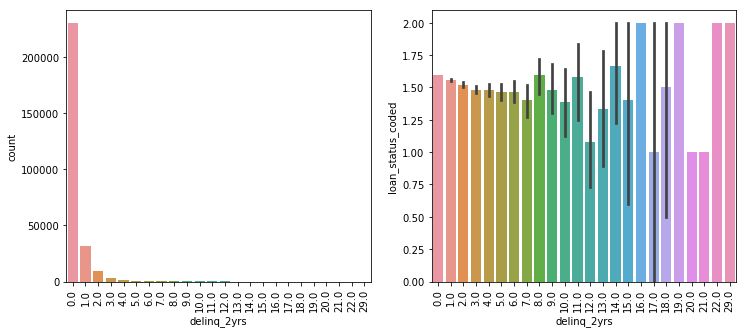

In [80]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["delinq_2yrs"])
plt.xticks(rotation="vertical")
plt.subplot(1,2,2)
sns.barplot(x="delinq_2yrs", y="loan_status_coded", data=loan)
plt.xticks(rotation="vertical")
plt.show()

### earliest_cr_line
* earliest_cr_line: The month the borrower's earliest reported credit line was opened

In [81]:
loan.earliest_cr_line.isnull().sum()

29

In [82]:
loan.earliest_cr_line.value_counts().head()

Oct-2000    2272
Oct-2001    2135
Oct-1999    2124
Nov-2000    2094
Aug-2000    2082
Name: earliest_cr_line, dtype: int64

This column has weak representation power. Let's drop this.

In [83]:
def drop_earliest_cr_line(data):
    data.drop('earliest_cr_line', axis=1, inplace=True)
    return None
drop_earliest_cr_line(loan)

### inq_last_6mths
* inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [84]:
loan.inq_last_6mths.isnull().sum()

29

In [85]:
loan.inq_last_6mths.value_counts()

0.0     134729
1.0      79298
2.0      37674
3.0      17340
4.0       4809
5.0       1973
6.0        832
7.0        193
8.0        118
9.0         50
10.0        24
12.0        15
11.0        15
15.0         9
14.0         6
13.0         6
18.0         4
16.0         3
19.0         2
17.0         2
24.0         2
28.0         1
31.0         1
32.0         1
25.0         1
33.0         1
20.0         1
27.0         1
Name: inq_last_6mths, dtype: int64

In [86]:
def fill_na_inq_last_6mths(data):
    data.inq_last_6mths.fillna(data.inq_last_6mths.median(), inplace=True)
    return None
fill_na_inq_last_6mths(loan)

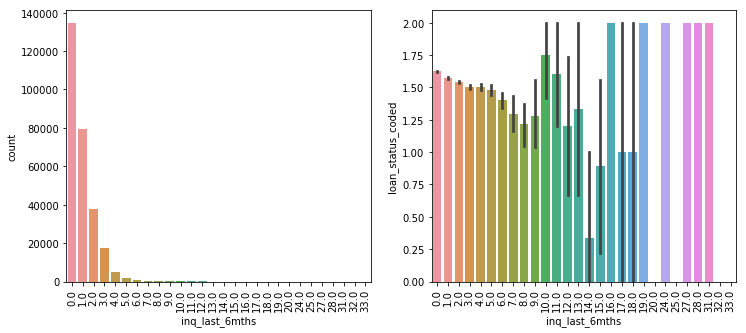

In [87]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["inq_last_6mths"])
plt.xticks(rotation="vertical")
plt.subplot(1,2,2)
sns.barplot(x="inq_last_6mths", y="loan_status_coded", data=loan)
plt.xticks(rotation="vertical")
plt.show()

### open_acc
* open_acc: The number of open credit lines in the borrower's credit file.

In [88]:
loan.open_acc.isnull().sum()

29

In [89]:
loan.open_acc.value_counts().head()

9.0     26475
8.0     25282
10.0    24994
11.0    23106
7.0     22843
Name: open_acc, dtype: int64

In [90]:
def fill_na_open_acc(data):
    data.open_acc.fillna(data.open_acc.median(), inplace=True)
    return None
fill_na_open_acc(loan)

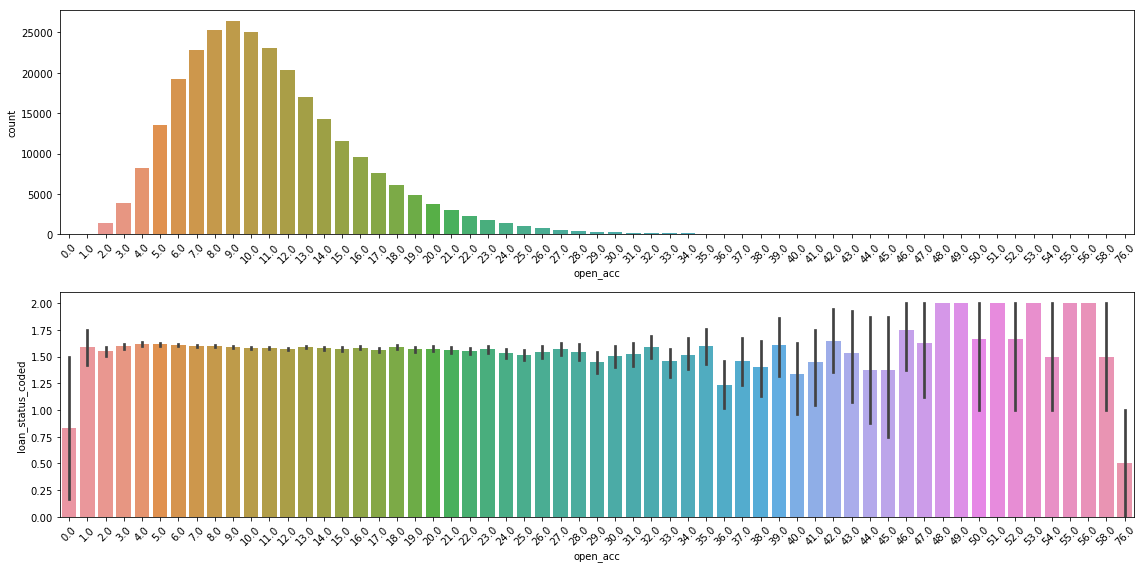

In [91]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
sns.countplot(loan["open_acc"])
plt.xticks(rotation=45)
plt.subplot(2,1,2)
sns.barplot(x="open_acc", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### pub_rec
* pub_rec: Number of derogatory public records

In [92]:
loan.pub_rec.isnull().sum()

29

In [93]:
loan.pub_rec.value_counts()

0.0     242299
1.0      30572
2.0       2975
3.0        805
4.0        249
5.0        110
6.0         53
7.0         20
8.0          9
9.0          7
10.0         5
11.0         3
12.0         2
15.0         1
20.0         1
Name: pub_rec, dtype: int64

In [95]:
def fill_na_pub_rec(data):
    data.pub_rec.fillna(data.pub_rec.median(), inplace=True)
    return None
fill_na_pub_rec(loan)

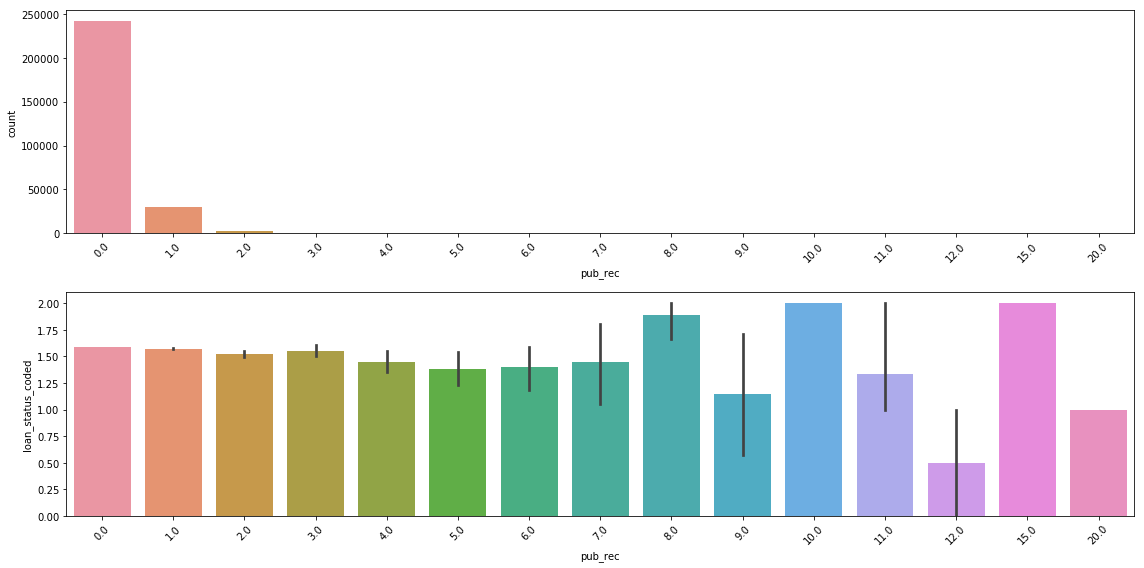

In [96]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
sns.countplot(loan["pub_rec"])
plt.xticks(rotation=45)
plt.subplot(2,1,2)
sns.barplot(x="pub_rec", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### revol_bal
* revol_bal: Total credit revolving balance

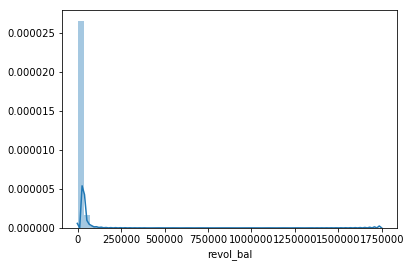

In [97]:
sns.distplot(loan.revol_bal)

(0, 100000)

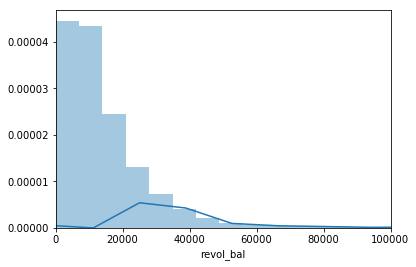

In [98]:
sns.distplot(loan.revol_bal, bins=250)
plt.xlim(0,100000)

The `revol_bal` feature also has a skewed distribution.

### revol_util
* revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [99]:
loan.revol_util.isnull().sum()

253

In [100]:
loan.revol_util.value_counts().head()

0.0     1947
63.0     490
62.0     488
61.0     485
58.0     480
Name: revol_util, dtype: int64

In [101]:
def fill_na_revol_util(data):
    data.revol_util.fillna(data.revol_util.median(), inplace=True)
    return None
fill_na_revol_util(loan)

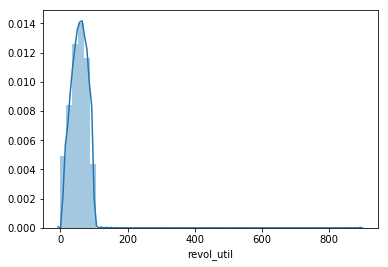

In [102]:
sns.distplot(loan.revol_util)

(0, 150)

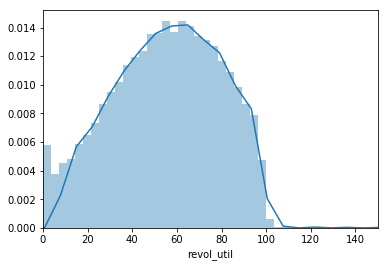

In [103]:
sns.distplot(loan.revol_util, bins=250)
plt.xlim(0,150)

### total_acc
* total_acc: The total number of credit lines currently in the borrower's credit file

In [104]:
loan.total_acc.isnull().sum()

29

In [105]:
loan.total_acc.value_counts().head()

20.0    10094
21.0    10046
22.0     9968
19.0     9770
23.0     9741
Name: total_acc, dtype: int64

In [106]:
def fill_na_total_acc(data):
    data.total_acc.fillna(data.total_acc.median(), inplace=True)
    return None
fill_na_total_acc(loan)

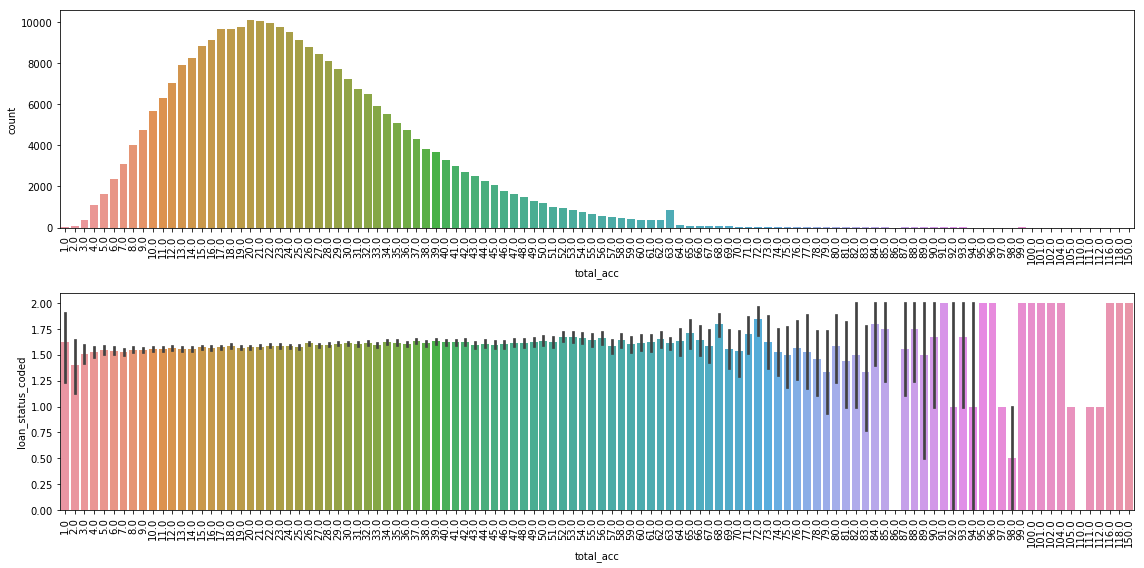

In [107]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
sns.countplot(loan["total_acc"])
plt.xticks(rotation="vertical")
plt.subplot(2,1,2)
sns.barplot(x="total_acc", y="loan_status_coded", data=loan)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

### initial_list_status
* initial_list_status: The initial listing status of the loan. Possible values are – W, F

In [108]:
loan.initial_list_status.value_counts()

f    196220
w     80920
Name: initial_list_status, dtype: int64

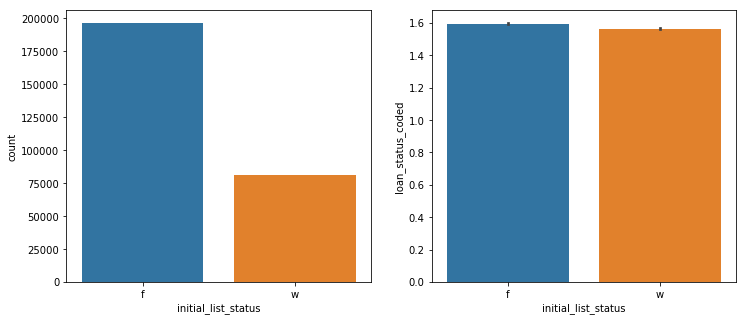

In [109]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["initial_list_status"])
plt.subplot(1,2,2)
sns.barplot(x="initial_list_status", y="loan_status_coded", data=loan)
plt.show()

### out_prncp, out_prncp_inv
* out_prncp: Remaining outstanding principal for total amount funded
* out_prncp_inv: Remaining outstanding principal for portion of total amount funded by investors

#### out_prncp

In [110]:
loan.out_prncp.value_counts().head(5)

0.0        255739
35000.0        31
10000.0        18
6000.0         16
5000.0         16
Name: out_prncp, dtype: int64

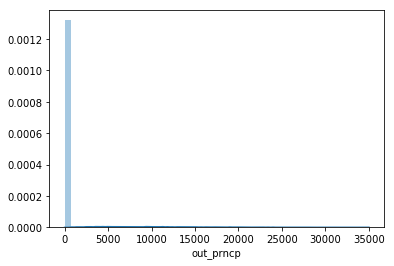

In [111]:
sns.distplot(loan.out_prncp)

In [112]:
loan.out_prncp.value_counts().head(5)/loan.shape[0] * 100

0.0        92.277910
35000.0     0.011186
10000.0     0.006495
6000.0      0.005773
5000.0      0.005773
Name: out_prncp, dtype: float64

We can think that almost all values are having value of 0. (92% of data are 0!).

In [113]:
def drop_out_prncp(data):
    data.drop('out_prncp', axis=1, inplace=True)
    return None
drop_out_prncp(loan)

#### out_prncp_inv

In [114]:
loan.out_prncp_inv.value_counts().head(5)

0.0        255739
35000.0        21
10000.0        16
6000.0         16
5000.0         16
Name: out_prncp_inv, dtype: int64

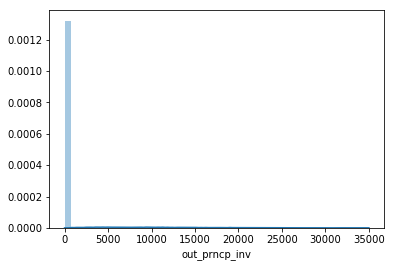

In [115]:
sns.distplot(loan.out_prncp_inv)

In [116]:
loan.out_prncp_inv.value_counts().head(5)/loan.shape[0] * 100

0.0        92.277910
35000.0     0.007577
10000.0     0.005773
6000.0      0.005773
5000.0      0.005773
Name: out_prncp_inv, dtype: float64

For the same reason as `out_prncp`, I will drop this column.

In [117]:
def drop_out_prncp_inv(data):
    data.drop('out_prncp_inv', axis=1, inplace=True)
    return None
drop_out_prncp_inv(loan)

### total_pymnt, total_pymnt_inv
* total_pymnt: Payments received to date for total amount funded

In [118]:
loan.total_pymnt.value_counts().head()

0.000000        592
11977.770391     57
12148.902155     51
11809.758589     43
12361.650008     33
Name: total_pymnt, dtype: int64

In [119]:
loan.total_pymnt_inv.value_counts().head()

0.00        870
11977.77     49
12148.90     46
11809.76     35
12361.65     33
Name: total_pymnt_inv, dtype: int64

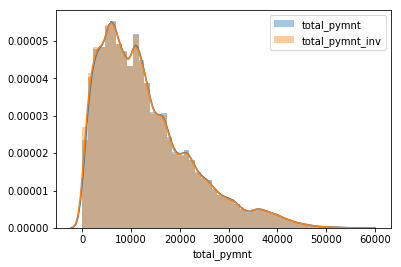

In [120]:
plt.figure()
sns.distplot(loan["total_pymnt"], label="total_pymnt")
sns.distplot(loan["total_pymnt_inv"], label="total_pymnt_inv")
plt.legend()
plt.xlabel("total_pymnt")
plt.show()

### total_rec_prncp, total_rec_int, total_rec_late_fee
* total_rec_prncp: Principal received to date
* total_rec_int: Interest received to date
* total_rec_late_fee: Late fees received to date

#### total_rec_prncp

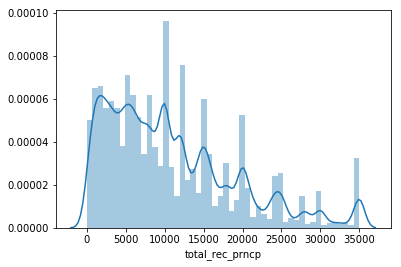

In [121]:
sns.distplot(loan.total_rec_prncp)

#### total_rec_int

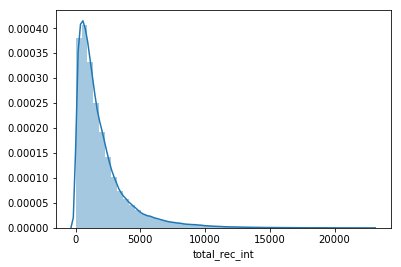

In [122]:
sns.distplot(loan.total_rec_int)

#### total_rec_late_fee

In [123]:
loan.total_rec_late_fee.value_counts().head()

0.0     267975
15.0      1758
30.0       214
45.0        49
60.0        16
Name: total_rec_late_fee, dtype: int64

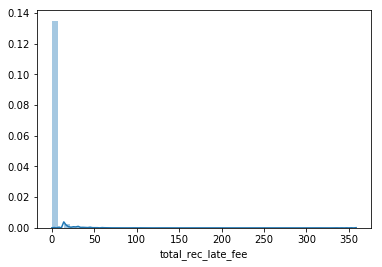

In [124]:
sns.distplot(loan.total_rec_late_fee)

Practically, most of `total_rec_late_fee` are gathered around 0. I will drop this column for computation efficiency.

In [125]:
def drop_total_rec_late_fee(data):
    data.drop('total_rec_late_fee', axis=1, inplace=True)
    return None
drop_total_rec_late_fee(loan)

### recoveries, collection_recovery_fee
* recoveries: post charge off gross recovery

In [126]:
loan.recoveries.value_counts().head(5)

0.00      252463
200.00        10
11.70          9
14.28          9
10.00          9
Name: recoveries, dtype: int64

In [127]:
loan.collection_recovery_fee.value_counts().head()

0.00    253633
2.00        18
1.80        13
1.20        12
1.55        12
Name: collection_recovery_fee, dtype: int64

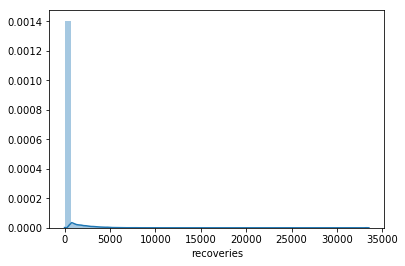

In [128]:
sns.distplot(loan.recoveries)

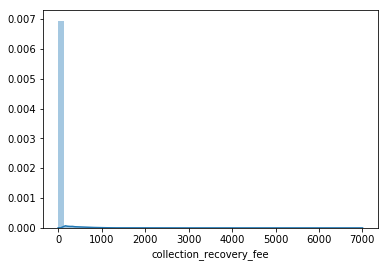

In [129]:
sns.distplot(loan.collection_recovery_fee)

In [130]:
def drop_recoveries(data):
    data.drop('recoveries', axis=1, inplace=True)
    return None
drop_recoveries(loan)

In [131]:
def drop_collection_recovery_fee(data):
    data.drop('collection_recovery_fee', axis=1, inplace=True)
    return None
drop_collection_recovery_fee(loan)

### last_pymnt_d
* Last month payment was received

In [132]:
loan.last_pymnt_d.value_counts().head()

Dec-2015    20237
Oct-2015    16000
Jul-2015    14483
Nov-2015    13981
Sep-2015    13834
Name: last_pymnt_d, dtype: int64

Last month when payment was received is provided in time format. It is ambiguous to apply as an unified rule for predicting loan's satatus. I will drop this column.

In [133]:
def drop_last_pymnt_d(data):
    data.drop('last_pymnt_d', axis=1, inplace=True)
    return None
drop_last_pymnt_d(loan)

### last_pymnt_amnt
* Last total payment amount received

In [134]:
loan.last_pymnt_amnt.value_counts().head()

0.0      935
100.0    274
200.0    211
300.0    153
50.0     145
Name: last_pymnt_amnt, dtype: int64

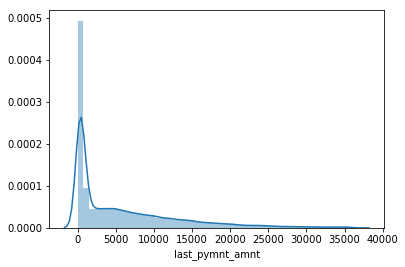

In [135]:
sns.distplot(loan.last_pymnt_amnt)

### last_credit_pull_d
* last_credit_pull_d: The most recent month LC pulled credit for this loan

In [136]:
loan.last_credit_pull_d.value_counts().head()

Jan-2016    123798
Dec-2015     18600
Nov-2015     11039
Oct-2015     10073
Sep-2015      9826
Name: last_credit_pull_d, dtype: int64

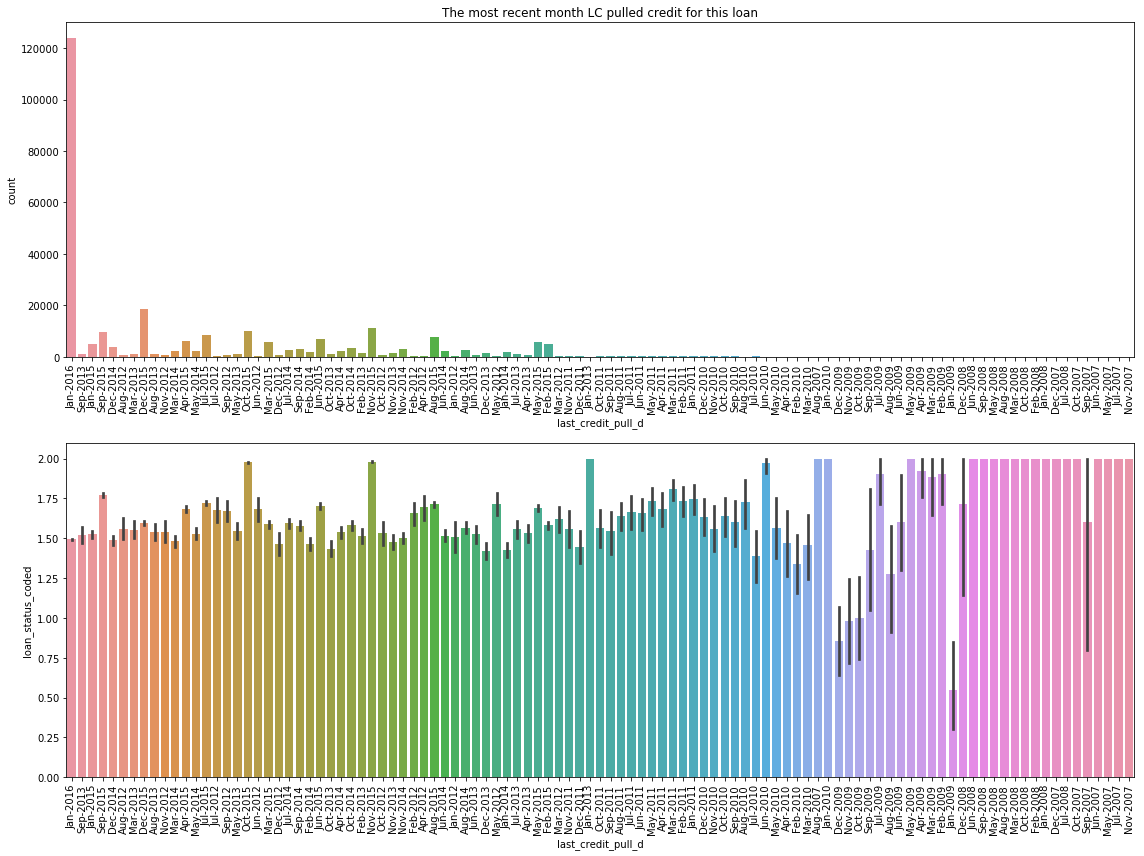

In [137]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.title('The most recent month LC pulled credit for this loan')
sns.countplot(loan["last_credit_pull_d"])
plt.xticks(rotation='vertical')
plt.subplot(2,1,2)
sns.barplot(x="last_credit_pull_d", y="loan_status_coded", data=loan)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

For the same reason as `issue_d`, I will drop this feature.

In [138]:
def drop_last_credit_pull_d(data):
    data.drop('last_credit_pull_d', axis=1, inplace=True)
    return None
drop_last_credit_pull_d(loan)

### collections_12_mths_ex_med
* collections_12_mths_ex_med: Number of collections in 12 months excluding medical collections

In [139]:
loan.collections_12_mths_ex_med.value_counts().head()

0.0    275061
1.0      1805
2.0       111
3.0        13
4.0         3
Name: collections_12_mths_ex_med, dtype: int64

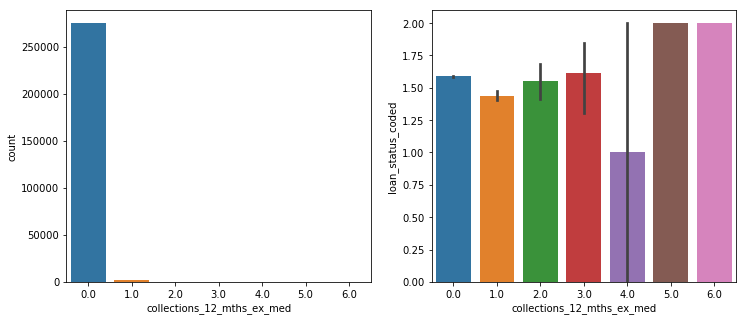

In [140]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["collections_12_mths_ex_med"])
plt.subplot(1,2,2)
sns.barplot(x="collections_12_mths_ex_med", y="loan_status_coded", data=loan)
plt.show()

This feature's value is mostly gathered in 0.0. It seems it cannot effectively provide information in predicting model. Let's drop this.

In [141]:
def drop_collections_12_mths_ex_med(data):
    data.drop('collections_12_mths_ex_med', axis=1, inplace=True)
    return None
drop_collections_12_mths_ex_med(loan)

### policy_code
* policy_code: 
    * publicly available policy_code=1
    * new products not publicly available policy_code=2

In [142]:
loan.policy_code.value_counts()

1.0    277140
Name: policy_code, dtype: int64

In [143]:
loan.shape[0]

277140

All of data are having this value of 1.0! Let's drop this feature for computation efficiency.

In [144]:
def drop_policy_code(data):
    data.drop('policy_code', axis=1, inplace=True)
    return None
drop_policy_code(loan)

### application_type
* application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [145]:
loan.application_type.value_counts()

INDIVIDUAL    277134
JOINT              6
Name: application_type, dtype: int64

In [146]:
loan.application_type.value_counts()/loan.shape[0] * 100

INDIVIDUAL    99.997835
JOINT          0.002165
Name: application_type, dtype: float64

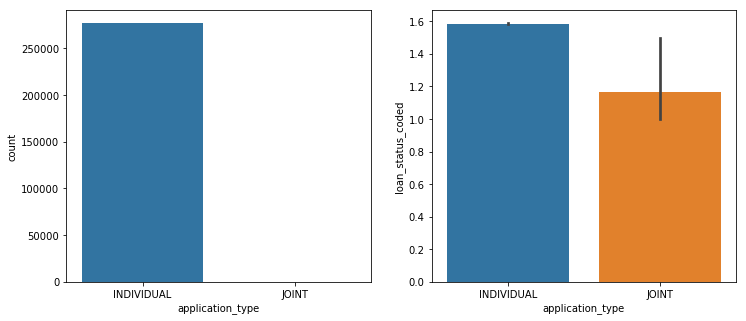

In [147]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["application_type"])
plt.subplot(1,2,2)
sns.barplot(x="application_type", y="loan_status_coded", data=loan)
plt.show()

Again, 99.998% of data are having this value as 'INDIVIDUAL'. Let's drop this column.

In [148]:
def drop_application_type(data):
    data.drop('application_type', axis=1, inplace=True)
    return None
drop_application_type(loan)

### acc_now_delinq
* acc_now_delinq: The number of accounts on which the borrower is now delinquent.

In [149]:
loan.acc_now_delinq.value_counts()

0.0    276224
1.0       836
2.0        44
3.0         3
5.0         2
4.0         2
Name: acc_now_delinq, dtype: int64

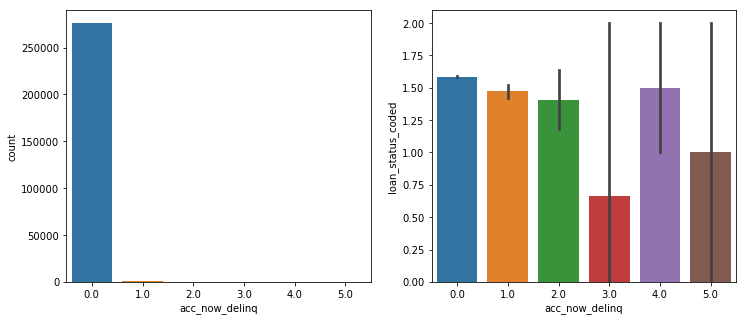

In [150]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["acc_now_delinq"])
plt.subplot(1,2,2)
sns.barplot(x="acc_now_delinq", y="loan_status_coded", data=loan)
plt.show()

In [151]:
def drop_acc_now_delinq(data):
    data.drop('acc_now_delinq', axis=1, inplace=True)
    return None
drop_acc_now_delinq(loan)

### tot_coll_amt, tot_cur_bal, total_rev_hi_lim
* tot_coll_amt: Total collection amounts ever owed
* tot_cur_bal: Total current balance of all accounts
* total_rev_hi_lim: Total revolving high credit/credit limit

#### tot_coll_amt

In [152]:
loan.tot_coll_amt.isnull().sum()/loan.shape[0]

0.24063289312260952

In [153]:
loan.tot_coll_amt.value_counts().head()/loan.shape[0]

0.0      0.669077
50.0     0.001432
100.0    0.001241
75.0     0.000992
150.0    0.000585
Name: tot_coll_amt, dtype: float64

24% of values are null and 67% are having 0.0 as its value. Let's drop this column.

In [157]:
def drop_tot_coll_amt(data):
    data.drop('tot_coll_amt', axis=1, inplace=True)
    return None
drop_tot_coll_amt(loan)

ValueError: labels ['tot_coll_amt'] not contained in axis

#### tot_cur_bal

In [158]:
loan.tot_cur_bal.isnull().sum()/loan.shape[0]

0.24063289312260952

In [159]:
loan.tot_cur_bal.value_counts().head(15)

0.0        53
25443.0    11
25341.0    10
19376.0    10
15043.0    10
16072.0     9
21944.0     9
31743.0     9
28674.0     9
29288.0     9
13530.0     9
4875.0      9
15886.0     9
30652.0     9
30491.0     9
Name: tot_cur_bal, dtype: int64

In [160]:
loan.tot_cur_bal.median()

78674.0

In [161]:
loan.tot_cur_bal.mean()

136880.27174496677

(0, 1000000.0)

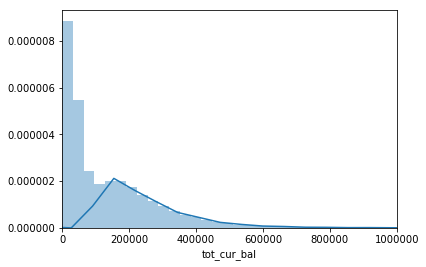

In [162]:
sns.distplot(loan.tot_cur_bal[loan.tot_cur_bal.isnull()==False], bins=250)
plt.xlim(0,0.1e7)

This column is very ambiguous to deal with. The 24% of the features are null values but it is hard to replace them with mean or median since this feature is widely distributed. I decided not to use this column in prediction.

In [163]:
def drop_tot_cur_bal(data):
    data.drop('tot_cur_bal', axis=1, inplace=True)
    return None
drop_tot_cur_bal(loan)

### total_rev_hi_lim

In [164]:
loan.total_rev_hi_lim.isnull().sum()/loan.shape[0]

0.24063289312260952

In [165]:
loan.total_rev_hi_lim.value_counts().head()

13500.0    753
9000.0     739
11500.0    730
15000.0    729
10000.0    726
Name: total_rev_hi_lim, dtype: int64

In [166]:
loan.total_rev_hi_lim.median()

22010.0

In [167]:
loan.total_rev_hi_lim.mean()

29435.476196359246

(0, 200000.0)

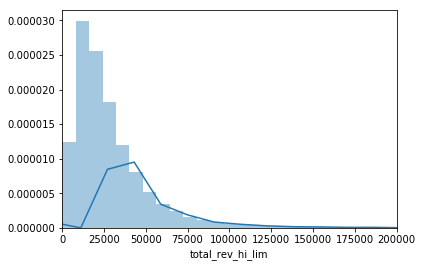

In [168]:
sns.distplot(loan.total_rev_hi_lim[loan.total_rev_hi_lim.isnull()==False], bins=250)
plt.xlim(0,2e5)

In this case, difference of mean and median are not as far as the `tot_cur_bal`, Let's replace them with median value.

In [169]:
def fill_na_total_rev_hi_lim(data):
    data.total_rev_hi_lim.fillna(data.total_rev_hi_lim.median(), inplace=True)
    return None
fill_na_total_rev_hi_lim(loan)

(0, 200000.0)

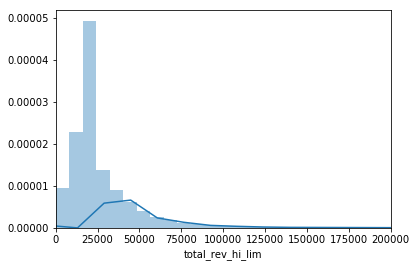

In [170]:
sns.distplot(loan.total_rev_hi_lim[loan.total_rev_hi_lim.isnull()==False], bins=250)
plt.xlim(0,2e5)

# One-hot Encoding

So far, we have confiremed that there are several categorical features. Let's define features and categorical features .

In [171]:
features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
            'total_rev_hi_lim', 'loan_status_coded']

categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']

In [172]:
loan = loan[features]

In [173]:
def one_hot_encoder(loan):
    categorical_variables = categorical
    loan_one_hot_encoded = pd.get_dummies(loan, columns=categorical_variables)
    print("====================[Data Types]====================")
    print(loan_one_hot_encoded.dtypes)
    return loan_one_hot_encoded
loan_one_hot_encoded = one_hot_encoder(loan)

====================[Data Types]====================
loan_amnt                              float64
funded_amnt                            float64
funded_amnt_inv                        float64
int_rate                               float64
installment                            float64
sub_grade                                int64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
last_pymnt_amnt                        float64
total_rev_hi_lim                       float64
loan_st

# Train-Test Split

Now, we have to split our data set to train and test sets.

In [174]:
from sklearn.model_selection import train_test_split

# Train-Test split
y = loan_one_hot_encoded.loan_status_coded
X = loan_one_hot_encoded.drop("loan_status_coded", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [175]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (221712, 66)
Shape of y_train:  (221712,)
Shape of x_test:  (55428, 66)
Shape of y_test:  (55428,)


# (Optional) SMOTE oversampling

We have to remind that distribution of our data is highly skewed.

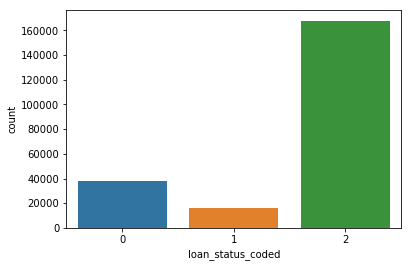

In [176]:
sns.countplot(y_train)

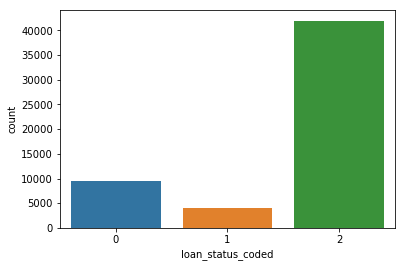

In [177]:
sns.countplot(y_test)

Most of `loan_status_coded` is 2 because the original data of loans were safe loans. This can affect our trianing model because just telling that every loan is safe loan can be the best answer in the perspective of accuracy. We can prevent it by following ways.

1. different weighting in training
2. downsample to the smallest set.
3. upsample to the largest set.

I implemented the upsampling by SMOTE alogirhtm below.

** Definition of SMOTE from Wikipedia**
>There are a number of methods available to oversample a dataset used in a typical classification problem (using a classification algorithm to classify a set of images, given a labelled training set of images). The most common technique is known as SMOTE: Synthetic Minority Over-sampling Technique.

To learn more about SMOTE, you can see the paper ['SMOTE: Synthetic Minority Over-sampling Technique.'](https://www.google.co.kr/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiqwaqtiY_VAhUEErwKHfuaDDQQFggmMAA&url=https%3A%2F%2Fwww.jair.org%2Fmedia%2F953%2Flive-953-2037-jair.pdf&usg=AFQjCNGdcP-u3VG9cnA9_eCa7LU1LTFNdw)

```
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd


def oversample_smote(X, y):
    print('Original dataset shape {}'.format(Counter(y)))
    sm = SMOTE()

    # Should apply SMOTE twice by OVA(one-versus-all).

    y_bad_set = y[y==0]
    y_warning_set = y[y==1]
    y_safe_set = y[y==2]

    X_bad_set = X.loc[y_bad_set.index]
    X_warning_set = X.loc[y_warning_set.index]
    X_safe_set = X.loc[y_safe_set.index]

    # warning_set versus all
    y_wva = y_safe_set.replace(2,0)
    y_wva = pd.concat([y_bad_set, y_warning_set, y_wva], axis=0)
    X_wva = pd.concat([X_bad_set, X_warning_set, X_safe_set], axis=0)
    X_wva_res, y_wva_res = sm.fit_sample(X_wva, y_wva)
    print('Resampled dataset shape {}'.format(Counter(y_wva_res)))

    y_warning = pd.Series(y_wva_res[y_wva_res==1]).sample(n=167769)
    X_warning = pd.DataFrame(X_wva_res[y_wva_res==1], columns=X_warning_set.columns).loc[y_warning.index]

    y_bva = y_safe_set.replace(2,1)
    y_bva = pd.concat([y_bad_set, y_warning, y_bva], axis=0)
    X_bva = pd.concat([X_bad_set, X_warning, X_safe_set], axis=0)
    X_bva_res, y_bva_res = sm.fit_sample(X_bva, y_bva)
    print('Resampled dataset shape {}'.format(Counter(y_bva_res)))

    y_bad = pd.Series(y_bva_res[y_bva_res==0]).sample(n=167769)
    X_bad = pd.DataFrame(X_bva_res[y_bva_res==0], columns=X_bad_set.columns).loc[y_bad.index]

    X_return = pd.concat([X_bad, X_warning, X_safe_set], axis=0)
    y_return = pd.concat([y_bad, y_warning, y_safe_set], axis=0)
    print('Resampled dataset shape {}'.format(Counter(y_return)))
    return X_return, y_return

# oversample by SMOTE
x_train, y_train = oversample_smote(x_train, y_train)
```

**However, I found that the problem of biased data can be resolved by inserting normalization layer instead of upsampling. Also, optimization goes faster with normalization layer rather than doing upsampling. Therefore I didn't use SMOTE upsampling in this demo.**

# Label Encoding for Target Feature for Training

Since this process is multi-class classifiation problem, we have to encode our label for training. This can be achieved by:

In [178]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y

# Neural Network model
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

Using TensorFlow backend.


In [179]:
y_train

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]], dtype=float32)

In [180]:
y_test

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]], dtype=float32)

# Neural Network Modeling

I used 2-layer neural network with 35 neurons in hidden layer. Batch normalization layer is inserted between hidden layer and output layer. The `categorical_crossentropy` is used as loss function and updating method is `ADAM`.

In [189]:
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
# create model
model = Sequential()
model.add(Dense(35, input_dim=66, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3))
model.add(Activation(tf.nn.softmax))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model summary:

In [190]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 35)                2345      
_________________________________________________________________
batch_normalization_9 (Batch (None, 35)                140       
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 108       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 2,593
Trainable params: 2,523
Non-trainable params: 70
_________________________________________________________________


Let's train this model by batch size of 40 with 30 epochs:

In [192]:
model.fit(np.array(x_train), np.array(y_train), epochs=30, batch_size=40, verbose=200)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


# Performance

Let's use our test set for evaluating this model.

In [193]:
scores = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
acc: 92.75%


Performance of maximum classifier will be around 75%

In [194]:
pd.DataFrame(y_test).sum(axis=0)/y_test.shape[0]

0    0.170419
1    0.072887
2    0.756693
dtype: float32

This model shows great performance on test set. Let's explore the prediction value.

In [195]:
preds = model.predict(np.array(x_test))
preds

array([[  3.23397759e-03,   2.12065945e-03,   9.94645357e-01],
       [  7.16354251e-01,   2.83645719e-01,   1.22260424e-10],
       [  6.44709289e-01,   3.55290383e-01,   3.10704053e-07],
       ..., 
       [  2.71716516e-09,   1.98897876e-09,   1.00000000e+00],
       [  1.10017403e-03,   6.25972811e-04,   9.98273849e-01],
       [  2.42983457e-03,   1.42353040e-03,   9.96146679e-01]], dtype=float32)

In [196]:
preds_class = model.predict_classes(np.array(x_test))
preds_class

array([2, 0, 0, ..., 2, 2, 2])

In [197]:
y_test

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]], dtype=float32)

We can see this model classifies loan in probablistic way.

Let's see the case this model misses:

In [198]:
y_class = pd.DataFrame(y_test).idxmax(axis=1)
y_class.tail()

55423    0
55424    2
55425    2
55426    2
55427    2
dtype: int64

Distribution of misclassification:

In [199]:
miss_class = y_class[y_class!=preds_class].value_counts()/y_class.shape[0]
miss_class

1    0.063957
0    0.008425
2    0.000126
dtype: float64

In [200]:
miss_df = pd.DataFrame(y_class[y_class!=preds_class].value_counts(), columns=['count_miss'])
miss_df

,count_miss
1,3545
0,467
2,7


Mostly, misclassification occured in `warning` and `bad` loan set.

## Confusion Matrix

In [201]:
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(y_class, preds_class)
cf_mat_p = cf_mat/cf_mat.sum()

In [202]:
cf_mat_p

array([[  1.61993938e-01,   5.39438551e-03,   3.03095908e-03],
       [  6.21346612e-02,   8.93050444e-03,   1.82218373e-03],
       [  7.21656924e-05,   5.41242693e-05,   7.56567078e-01]])

In [ ]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','warning','safe'], yticklabels=['bad','warning','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()

# More...

As shown before, this model shows considerably accurate performance. Most of misclassification occurred when it distinguish `warning` and `bad` loans. I wondered how this model will perform if it works as a binary classifier without some features.

Let's assume we cannot use `grade` and `sub-grade` features, which are rated by Lending Club. And Change our model from multi-class classifier to binary classifier.

In [ ]:
# remove 'grade' and 'sub_grade'
features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'installment', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
            'total_rev_hi_lim', 'loan_status_coded']

# remove 'grade'
categorical = ['term', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']

And let's modify our `categorize_target` function to be a binary categorizer:

In [ ]:
def categorize_target(data):
    """Returns encoded loan status: Safe, Warning and Bad"""

    def func(x):
        if x['loan_status'] in bad_index:
            return 0
        elif x['loan_status'] in warning_index:
            return 0
        else:
            return 1

    data['loan_status_coded'] = data.apply(func, axis=1)
    data.drop('loan_status', axis=1, inplace=True)
    return data

In [ ]:
def trim_features(loan):
    ext_num_from_sub_grade(loan)
    drop_emp_title(loan)
    fill_na_annual_inc(loan)
    drop_zip_code(loan)
    fill_na_delinq_2yrs(loan)
    drop_earliest_cr_line(loan)
    fill_na_inq_last_6mths(loan)
    fill_na_open_acc(loan)
    fill_na_pub_rec(loan)
    fill_na_revol_util(loan)
    fill_na_total_acc(loan)
    drop_pymnt_plan(loan)
    drop_url(loan)
    drop_total_rec_late_fee(loan)
    drop_out_prncp(loan)
    drop_out_prncp_inv(loan)
    drop_recoveries(loan)
    drop_collection_recovery_fee(loan)
    drop_last_pymnt_d(loan)
    drop_collections_12_mths_ex_med(loan)
    drop_policy_code(loan)
    drop_application_type(loan)
    drop_acc_now_delinq(loan)
    drop_tot_coll_amt(loan)
    drop_tot_cur_bal(loan)
    fill_na_total_rev_hi_lim(loan)
    drop_issue_d(loan)
    drop_addr_state(loan)
    drop_last_credit_pull_d(loan)


In [ ]:
# load data
loan = pd.read_csv('./data/loan.csv')

# pre-process data
drop_null_columns(loan)
loan_in_progress = split_loan_in_progress(loan)
loan = categorize_target(loan)

# Feature Engineering by EDA
trim_features(loan)

# one-hot encoding
loan = loan[features]
loan_one_hot_encoded = one_hot_encoder(loan)

# Train-Test split
y = loan_one_hot_encoded.loan_status_coded
X = loan_one_hot_encoded.drop("loan_status_coded", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# In this case, we don't have to encode target variable.
# Neural Network model
#y_train = encode_neural_net_y(y_train)
#y_test = encode_neural_net_y(y_test)

Let's train this model:

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=58, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=40, verbose=1)

## Performance of Binary Classifier (Classifying Good/Bad loans)

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

This model classifies almost perfectly! Considering the former model, we can guess that this model could miss the classification between 'warning' and 'bad' loans but it almost never misses classifying 'good' versus 'warning' & 'bad' loans. It is commercially acceptible because it suppresses the 'bad' loans to be recognized as 'safe'. ('warning' and 'bad' loans will be underwrited by human underwriter)

In [ ]:
bi_preds_class = model.predict_classes(np.array(x_test))
bi_preds_class

In [ ]:
y_test.tail()

In [ ]:
miss_class = y_test[y_test!=bi_preds_class].value_counts()/y_test.shape[0]
miss_class

In [ ]:
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(y_test, bi_preds_class)
cf_mat_p = cf_mat/cf_mat.sum()

In [ ]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','safe'], yticklabels=['bad','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()